<a href="https://colab.research.google.com/github/REICHIYAN/REI/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


File not found...downloading the GOOG data


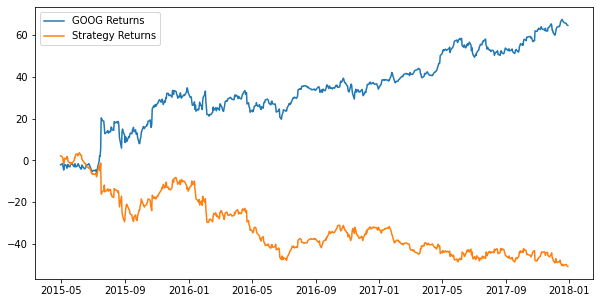

0.5423476968796433 0.4821958456973294
3.758254921717732


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


from pandas_datareader import data

def load_financial_data(start_date, end_date,output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        df = data.DataReader('GOOG', 'yahoo', start_date, end_date)
        df.to_pickle(output_file)
    return df

goog_data=load_financial_data(start_date='2001-01-01',
                    end_date = '2018-01-01',
                    output_file='goog_data_large.pkl')




def create_trading_condition(df):
    df['Open-Close']=df.Open-df.Close
    df['High-Low']=df.High-df.Low
    df=df.dropna()
    X=df[['Open-Close','High-Low']]
    Y=np.where(df['Close'].shift(-1)>df['Close'],1,-1)
    return (X,Y)

def create_train_split_group(X,Y,split_ratio=0.8):
    return train_test_split(X,Y,shuffle=False,train_size=split_ratio)

X,Y=create_trading_condition(goog_data)

X_train,X_test,Y_train,Y_test=\
    create_train_split_group(X,Y,split_ratio=0.8)

# Fit the model
svc=SVC()
svc.fit(X_train, Y_train)
# Forecast value

goog_data['Predicted_Signal']=svc.predict(X)
goog_data['GOOG_Returns']=np.log(goog_data['Close']/
                                 goog_data['Close'].shift(1))


def calculate_return(df,split_value,symbol):
    cum_goog_return= df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns']= df['%s_Returns' % symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return

def calculate_strategy_return(df,split_value):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_goog_return=calculate_return(goog_data,split_value=len(X_train),symbol='GOOG')
cum_strategy_return= calculate_strategy_return(goog_data,split_value=len(X_train))


def plot_shart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10,5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return,label='Strategy Returns')
    plt.legend()
    plt.show()

plot_shart(cum_goog_return, cum_strategy_return,symbol='GOOG')

def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std=strategy_returns.std()
    sharpe=(strategy_returns-symbol_returns)/strategy_std
    return sharpe.mean()

accuracy_train = accuracy_score(Y_train, svc.predict(X_train))
accuracy_test = accuracy_score(Y_test, svc.predict(X_test))
print(accuracy_train, accuracy_test)
print(sharpe_ratio(cum_strategy_return,cum_goog_return))